In [3]:
#external packages
import numpy as np
import math
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import time
from numpy.lib.recfunctions import append_fields
from astropy.cosmology import FlatLambdaCDM,Planck15
from matplotlib.backends.backend_pdf import PdfPages
import sys
import random
%load_ext autoreload

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

sys.path.append('/home/almhatre/data')

In [4]:
import AGNclustering.kNN_functions as k
from AGNclustering.KNN_stuff import CDFkNN_rp_pi
from AGNclustering.kNN_error import kNN_ratio_error, block_test, kNN_chi_squared,kNN_diff_error,chop_cdf, angular_chop_cdf
from AGNclustering.utils import z_to_cdist
from AGNclustering.wppi_utils import control_mult_var,control_var
from AGNclustering.angular_kNN import CDFkNN_theta

In [5]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
data_directory = '/home/almhatre/data/BASS/'
cat = Table.read(data_directory + 'data_dr2.csv',format='csv')
agnt =np.array(cat)
agn = agnt[ (agnt['L210']>42.5) & (agnt['z']>.01)&(agnt['z']<=.1) ]
t = Table.read(data_directory +'2mrs_noAGN.csv',format='csv')
gal =np.array(t)
gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN
agn.dtype.names

('col0',
 'bat_index',
 'Counterpart',
 'Type',
 'z',
 'Mbh',
 'Method',
 'Edd_rat',
 'L_edd',
 'L_bol',
 'NH',
 'L210',
 'ra',
 'dec',
 'L14195',
 'AGN',
 'flux',
 'Snu_1',
 'Snu_6',
 'Morphology',
 'log_Ms',
 'Lir_sf')

In [7]:
nonzero=(agn["Mbh"]>0)
agnmass=agn[nonzero]
zbins=np.arange(0.01,.11,.01)
percentile=33

# #In order to control for Edd_rat
# nonzero=((agnmass["Edd_rat"]>0) & (agnmass["Edd_rat"]<1))
# agnmass = agnmass[nonzero]
             

# stmin=np.min(agnmass['log_Ms'][agnmass['log_Ms']>8])
# stmax=np.max(agnmass['log_Ms'][agnmass['log_Ms']>8])
# increm=(stmax-stmin)/5
# msbins=np.arange(stmin,stmax+increm,increm)

# increm=(stmax-stmin)/9
# msbinsmod=np.arange(stmin,stmax+increm,increm)


# stmin=np.min(agnmass['Mbh'][agnmass['Mbh']>0])
# stmax=np.max(agnmass['Mbh'][agnmass['Mbh']>0])
# increm=(stmax-stmin)/9
# massbins=np.arange(stmin,stmax+increm,increm)

In [10]:
%autoreload 2

# #Controlling for 2 vars
# lower, mid, upper = control_mult_var(agn=agnmass,bins1=zbins,bins2=massbins,control1='z',control2='Mbh',var='L210',percentile=50)

#Controlling for a singular var
l, m, up = control_var(agn=agnmass,bins=zbins,control='z',var='Edd_rat',percentile=percentile)


In [11]:
# #Splitting into separate redshiftbins
# zmin = 0.01
# zmax = 0.04

# nonzero = ((l['z']>=zmin) & (l['z']<zmax))
# nonzero2=((up['z']>=zmin) & (up['z']<zmax))

# l = l[nonzero]
# up = up[nonzero2]

In [12]:
decg = agn['dec'] * ((np.pi)/180.0)
rag = agn['ra'] * ((np.pi)/180.0)

decr = gal['dec'] * ((np.pi)/180.0)
rar = gal['ra'] * ((np.pi)/180.0)

degree_min = .5
degree_max = 1

kneighbors = 4

anglestemp = np.linspace(degree_min*np.pi/180.0, degree_max*np.pi/180.0, 6)
angles = anglestemp[:-1]
angles = angles[1:]
angleslist = []


outputhightemp, errhightemp, covhigh = k.angular_kNN_wrapper(anglestemp, up, gal, kneighbors,
                                                             angleslist, concatenate = True, m=6)
outputlowtemp, errlowtemp, covlow =  k.angular_kNN_wrapper(anglestemp, l, gal, kneighbors,
                                                             angleslist, concatenate = True, m=6)

Ngal 38567 Nrand 211 4
build tree 0.024982929229736328
query 0.00722503662109375
  kdtree tot 0.032250404357910156
(211, 4) [0.         0.00872665 0.01047198 0.0122173  0.01396263 0.01570796
 0.01745329]
  cdf 0.0011510848999023438
Using  36  jacknife samples
1 / 36
Ngal 38246 Nrand 208 4
build tree 0.02223992347717285
query 0.005615234375
  kdtree tot 0.027891159057617188
(208, 4) [0.         0.00872665 0.01047198 0.0122173  0.01396263 0.01570796
 0.01745329]
  cdf 0.0006277561187744141
2 / 36
Ngal 37441 Nrand 203 4
build tree 0.02175307273864746
query 0.005766391754150391
  kdtree tot 0.02755260467529297
(203, 4) [0.         0.00872665 0.01047198 0.0122173  0.01396263 0.01570796
 0.01745329]
  cdf 0.0005521774291992188
3 / 36
Ngal 36636 Nrand 201 4
build tree 0.021416664123535156
query 0.005324602127075195
  kdtree tot 0.026774168014526367
(201, 4) [0.         0.00872665 0.01047198 0.0122173  0.01396263 0.01570796
 0.01745329]
  cdf 0.0005633831024169922
4 / 36
Ngal 36481 Nrand 202 4

query 0.0052793025970458984
  kdtree tot 0.025092363357543945
(202, 4) [0.         0.00872665 0.01047198 0.0122173  0.01396263 0.01570796
 0.01745329]
  cdf 0.0007534027099609375
35 / 36
Ngal 37839 Nrand 207 4
build tree 0.020328760147094727
query 0.005365848541259766
  kdtree tot 0.025724172592163086
(207, 4) [0.         0.00872665 0.01047198 0.0122173  0.01396263 0.01570796
 0.01745329]
  cdf 0.0005357265472412109
36 / 36
Ngal 38434 Nrand 211 4
build tree 0.02060103416442871
query 0.005582571029663086
  kdtree tot 0.02621293067932129
(211, 4) [0.         0.00872665 0.01047198 0.0122173  0.01396263 0.01570796
 0.01745329]
  cdf 0.0005483627319335938
Ngal 38567 Nrand 212 4
build tree 0.02204608917236328
query 0.005621910095214844
  kdtree tot 0.02769637107849121
(212, 4) [0.         0.00872665 0.01047198 0.0122173  0.01396263 0.01570796
 0.01745329]
  cdf 0.0005383491516113281
Using  36  jacknife samples
1 / 36
Ngal 38246 Nrand 210 4
build tree 0.02037644386291504
query 0.0051434040069

Ngal 36848 Nrand 200 4
build tree 0.020416975021362305
query 0.004869937896728516
  kdtree tot 0.025317907333374023
(200, 4) [0.         0.00872665 0.01047198 0.0122173  0.01396263 0.01570796
 0.01745329]
  cdf 0.0005660057067871094
35 / 36
Ngal 37839 Nrand 210 4
build tree 0.020354747772216797
query 0.005274772644042969
  kdtree tot 0.025658369064331055
(210, 4) [0.         0.00872665 0.01047198 0.0122173  0.01396263 0.01570796
 0.01745329]
  cdf 0.0005247592926025391
36 / 36
Ngal 38434 Nrand 209 4
build tree 0.02063751220703125
query 0.005154132843017578
  kdtree tot 0.02581954002380371
(209, 4) [0.         0.00872665 0.01047198 0.0122173  0.01396263 0.01570796
 0.01745329]
  cdf 0.0005345344543457031


In [13]:
#Deleting first and last sampling from each output
outputhigh = np.delete(outputhightemp, -1, axis=1)

outputlow = np.delete(outputlowtemp, -1, axis=1)

errhigh = np.delete(errhightemp, -1, axis=1)

errlow = np.delete(errlowtemp, -1, axis=1)

outputhigh = np.delete(outputhigh, 0, axis=1)

outputlow = np.delete(outputlow, 0, axis=1)

errhigh = np.delete(errhigh, 0, axis=1)

errlow = np.delete(errlow, 0, axis=1)

In [14]:
conditionhigh = np.linalg.cond(covhigh)
conditionlow = np.linalg.cond(covlow)
conditioncombined = np.linalg.cond(covlow+covhigh)

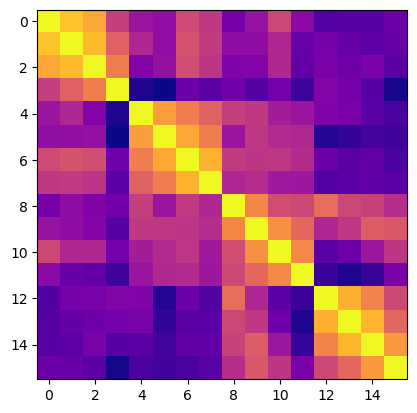

In [15]:
combined_cov = covhigh+covlow
corr_matrix = np.zeros((len(covhigh),len(covhigh)))
for i in range(len(covhigh)):
    for j in range(len(covhigh)):
        corr_matrix[i,j] = (combined_cov[i,j])/(math.sqrt(combined_cov[i,i]*combined_cov[j,j]))
        
plt.imshow(corr_matrix, cmap = 'plasma')

In [16]:
print("condition number of high mass subsample: " , conditionhigh)
print("condition number of low mass subsample: " , conditionlow)
print("condition number of combined sample: " , conditioncombined)
print(errhigh)

condition number of high mass subsample:  1443.219099347182
condition number of low mass subsample:  219.33359163426837
condition number of combined sample:  182.73525158449223
[[0.02891003 0.02062888 0.0189358  0.01098069]
 [0.03487545 0.03203725 0.0302568  0.02885623]
 [0.03954844 0.03737175 0.03528458 0.02827702]
 [0.06736253 0.06026072 0.05849011 0.04615187]]


In [17]:
# #Stuff for sampling each neighbor individually
# outputhighconc = np.zeros((kneighbors,3))
# for i in range(kneighbors):
#     outputhighconc[i] = outputhigh[i][angleslist[i][:-1]]
    
    
# outputlowconc = np.zeros((kneighbors,3))
# for i in range(kneighbors):
#     outputlowconc[i] = outputlow[i][angleslist[i][:-1]]
    

Text(0.5, 0, 'Degrees')

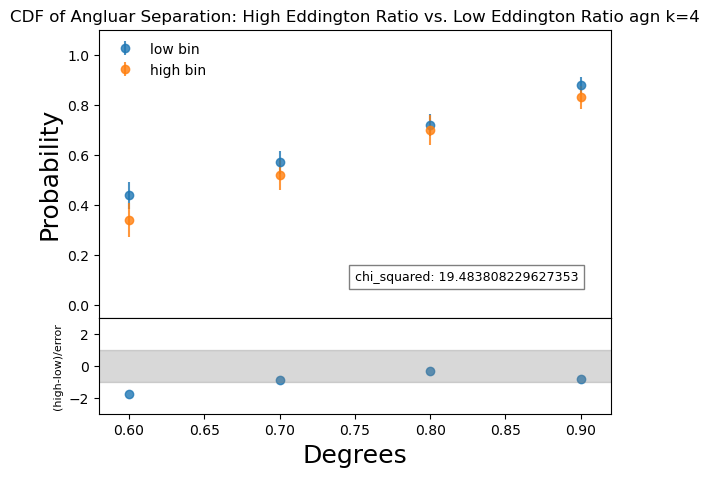

In [18]:
neighbor = 4

anglemax = angles[-1] * 180/(math.pi)
anglemin = angles[0] * 180/(math.pi)

ind = neighbor - 1

#Calculate relevant values
chi_squared = kNN_chi_squared(outputhigh,outputlow,covhigh,covlow,concatenate=True)
differr = kNN_diff_error(outputhigh[ind],outputlow[ind],errhigh[ind],errlow[ind],single_neighbor=True)
chi_strnew = 'chi_squared: '+ str(chi_squared)

#Main Plot
fig1 = plt.figure(1)
frame1=fig1.add_axes((.1,.3,.8,.6),yticks=[.0,.2,.4,.6,.8,1.0])
plt.errorbar(angles * 360/(2*math.pi), outputlow[ind], yerr=errlow[ind],fmt='o',label='low bin',alpha=0.8)
plt.errorbar(angles * 360/(2*math.pi), outputhigh[ind], yerr=errhigh[ind],fmt='o',label='high bin',alpha=0.8)
plt.ylabel('Probability',fontsize=18)
plt.legend(frameon=False,numpoints=1,loc=2)
plt.title('CDF of Angluar Separation: High Eddington Ratio vs. Low Eddington Ratio agn k=' + str(neighbor))
plt.axis([anglemin -.02, anglemax+.02,-.05,1.1])
plt.text(0.75, 0.1, chi_strnew, fontsize=9,bbox = dict(facecolor = 'white', alpha = 0.5))


#Subplot
frame2=fig1.add_axes((.1,.1,.8,.2),yticks=[-2,0,2])
plt.scatter(angles * 360/(2*math.pi),(outputhigh[ind]-outputlow[ind])/differr[ind],label='high-low',alpha=0.8)
plt.fill_between([-1,1],[1,1],[-1,-1],color='gray',alpha=0.3)
plt.ylabel('(high-low)/error',fontsize=8)
plt.axis([anglemin -.02, anglemax+.02,-3.01,3.01])
plt.xlabel('Degrees',fontsize=18)



In [20]:
# #Cell for finding angle cutoffs for each neighbor -- not working for angular kNN

# neighbor = 8

# ind = neighbor - 1


# anglesnew,highnew,lownew,errhighnew, errlownew, covhighnew,covlownew = \
# angular_chop_cdf(angles,outputhigh[ind],outputlow[ind],errhigh[ind],errlow[ind],covhigh[ind],covlow[ind])


# addit = [(anglesnew[0],anglesnew[-1])]


# anglelimits = np.append(anglelimits,addit,axis=0)

# fig1 = plt.figure(1)
# frame1=fig1.add_axes((.1,.3,.8,.6),yticks=[.0,.2,.4,.6,.8,1.0])
# plt.errorbar(anglesnew,lownew,yerr=errlownew,fmt='o',label='low mass',alpha=0.8)
# plt.errorbar(anglesnew,highnew,yerr=errhighnew,fmt='o',label='high mass',alpha=0.8)
# plt.ylabel('Probability',fontsize=12)
# plt.legend(frameon=False,numpoints=1,loc=2)
# plt.title('CDF of Rp: High luminosity vs. Low luminosity k=' + str(neighbor))
# # plt.text(30, 0.25, chi_strnew, fontsize=9,bbox = dict(facecolor = 'white', alpha = 0.5))

# plt.axis([anglemin - 0.05, anglemax + 0.05,-.05,1.1])

# print(anglelimits)